# Delete Using Python

In [ ]:
# import shutil

# shutil.rmtree("/content/dataset")
# print("Delete  folder.")

# Unzip dataset.zip in /content/

In [ ]:
# import zipfile
# import os

# zip_path = "/content/dataset.zip"
# extract_dir = "/content/"

# # create a folder and extract
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#   zip_ref.extractall(extract_dir)

# print("Unzipped Successfully to: ", extract_dir)

#🚗 Car Model Classification with OOD Detection using Multi-Head Architecture

## 1. Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
from PIL import Image
from typing import List, Tuple
import random
from pathlib import Path
import torch.nn.functional as F


In [ ]:
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 1. Custom Dataset Class for OOD Detection

In [ ]:
class CarDatasetWithOOD(Dataset):
  def __init__(self, root_dir, transform=None):
    self.transform = transform
    self.samples = []

    # car classes (4 car classes)
    car_classes =  ['Maruti_Suzuki_Baleno', 'Maruti_Suzuki_Brezza',
                    'Maruti_Suzuki_Swift', 'Maruti_Suzuki_WagonR']

    # Add car samples
    for idx, class_name in enumerate(car_classes):
      class_path = os.path.join(root_dir, class_name)

      if os.path.exists(class_path):
        for img_name in os.listdir(class_path):
          if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            self.samples.append({
                'path': os.path.join(class_path, img_name),
                'car_class': idx,      # 0,1,2,3
                'is_car': 1            # Binary: this is a car
            })

    # Add OOD samples (Not_Car folder)
    ood_path = os.path.join(root_dir, "Not_Car")
    if os.path.exists(ood_path):
      for img_name in os.listdir(ood_path):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
          self.samples.append({
              'path': os.path.join(ood_path, img_name),
              'car_class': -1,   # No car class
              'is_car': 0        # Binary: this is NOT a Car
          })

    print(f"Loaded {len(self.samples)} samples from {root_dir}")

    # Count distribution
    car_count = 0
    ood_count = 0

    for sample in self.samples:
      if sample["is_car"] == 1:
        car_count += 1
      else:
        ood_count += 1

    print(f"Car Images: {car_count}, OOD Images: {ood_count}")

  def __len__(self):
    return len(self.samples)

  def __getitem__(self,idx):
    sample = self.samples[idx]
    image = Image.open(sample['path']).convert('RGB')

    if self.transform:
      image = self.transform(image)

    return image, sample['car_class'], sample['is_car']

## 2. Multi-Head Model Architecture

In [ ]:
class CarClassifierWithOOD(nn.Module):
  def __init__(self, num_car_classes=4, pretrained=True):
    super(CarClassifierWithOOD, self).__init__()

    # Load EfficientNet-B0 backbone
    if pretrained:
      weights = models.EfficientNet_B0_Weights.DEFAULT
    else:
      weights = None

    self.backbone = models.efficientnet_b0(weights=weights)

    # Remove the original classifier
    self.backbone.classifier = nn.Identity()

    # Freeze base layers
    for param in self.backbone.features.parameters():
        param.requires_grad = False

    # Unfreeze last 2 blocks for fine-tuning
    for param in self.backbone.features[-2:].parameters():
        param.requires_grad = True

    # Feature dimension for EfficientNet-B0
    feature_dim = 1280

    # Car classification head (4 classes)
    self.car_classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(feature_dim, num_car_classes)
    )

    # OOD detection head (binary: car vs not-car)
    self.ood_classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(feature_dim, 1)
    )

  def forward(self, x):
    # Extract features from backbone
    features = self.backbone(x)

    # Get predictions from both heads
    car_logits = self.car_classifier(features)  # [batch_size, 4]
    ood_logits = self.ood_classifier(features)  # [batch_size, 1]

    return car_logits, ood_logits

## 3. Data Preparation

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456, 0.406],
                       std=[0.229,0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                       std=[0.229,0.224,0.225])
])

#### Load datasets with custom dataset class


In [ ]:
train_dir = "./dataset/train"
val_dir = "./dataset/val"
test_dir = "./dataset/test"

In [ ]:
# 1. Training Dataset
train_data = CarDatasetWithOOD(train_dir, transform=train_transform)

# 2. Validation Dataset
val_data = CarDatasetWithOOD(val_dir, transform=test_transform)

# 3. Test Dataset
test_data = CarDatasetWithOOD(test_dir, transform=test_transform)

Loaded 562 samples from ./dataset/train
Car Images: 392, OOD Images: 170
Loaded 122 samples from ./dataset/val
Car Images: 83, OOD Images: 39
Loaded 123 samples from ./dataset/test
Car Images: 88, OOD Images: 35


In [ ]:
# Class names for car classification
class_names = ['Maruti_Suzuki_Baleno', 'Maruti_Suzuki_Brezza',
               'Maruti_Suzuki_Swift', 'Maruti_Suzuki_WagonR']

In [ ]:
BATCH_SIZE = 42

In [ ]:
# 1. Training DataLoader
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# 2. Validation DataLoader
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# 3. Test DataLoader
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## 4. Initialize Multi-Head Model

In [ ]:
model = CarClassifierWithOOD(num_car_classes=4, pretrained=True).to(device)

In [ ]:
!pip install torchinfo

In [ ]:
# Display model summary
from torchinfo import summary
summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=19,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape         Output Shape        Param #             Trainable
CarClassifierWithOOD (CarClassifierWithOOD)                       [32, 3, 224, 224]   [32, 4]             --                  Partial
├─EfficientNet (backbone)                                         [32, 3, 224, 224]   [32, 1280]          --                  Partial
│    └─Sequential (features)                                      [32, 3, 224, 224]   [32, 1280, 7, 7]    --                  Partial
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]   [32, 32, 112, 112]  (928)               False
│    │    └─Sequential (1)                                        [32, 32, 112, 112]  [32, 16, 112, 112]  (1,448)             False
│    │    └─Sequential (2)                                        [32, 16, 112, 112]  [32, 24, 56, 56]    (16,714)            False
│    │    └─Sequential (3)                                        

## 5. Training Components

In [ ]:
LEARNING_RATE = 0.001

In [ ]:
# 1.Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# 2. Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=2, factor=0.5)

## Implement Early Stopping

In [ ]:
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0.001):
    self.patience = patience      # How many epochs to wait before stopping
    self.min_delta = min_delta    # Minimum improvement threshold
    self.counter = 0              # Count epochs without improvement
    self.best_loss = None         # Track the best validation loss seen
    self.early_stop = False       # Flag to indicate when to stop training


  def __call__(self, val_loss):
    if self.best_loss is None:
        # First epoch - initialize best loss
        self.best_loss = val_loss

    elif val_loss < self.best_loss - self.min_delta:
        # Significant improvement found
        self.best_loss = val_loss
        self.counter = 0  # Reset patience counter

    else:
        # No significant improvement
        self.counter += 1
        if self.counter >= self.patience:
            self.early_stop = True  # Trigger early stopping

## 6. Updated Training Functions with Dual Loss

In [ ]:
def compute_dual_loss(car_logits, ood_logits, car_labels, is_car_labels, car_weight=1.0, ood_weight=0.5):
    """
    Compute combined loss for both car classification and OOD detection
    """
    # Car classification loss (only for car images)
    car_mask = is_car_labels == 1
    if car_mask.sum() > 0:
        car_loss = F.cross_entropy(car_logits[car_mask], car_labels[car_mask])
    else:
        car_loss = torch.tensor(0.0, device=car_logits.device)

    # OOD detection loss (for all images)
    ood_loss = F.binary_cross_entropy_with_logits(
        ood_logits.squeeze(), is_car_labels.float()
    )

    # Combined loss
    total_loss = car_weight * car_loss + ood_weight * ood_loss
    return total_loss, car_loss, ood_loss

In [ ]:
def train_step_dual(model, dataloader, optimizer, device):
    model.train()
    total_loss, car_loss_sum, ood_loss_sum = 0, 0, 0
    car_correct, ood_correct, car_total, ood_total = 0, 0, 0, 0

    for images, car_labels, is_car_labels in dataloader:
        images = images.to(device)
        car_labels = car_labels.to(device)
        is_car_labels = is_car_labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        car_logits, ood_logits = model(images)

        # Compute dual loss
        loss, car_loss, ood_loss = compute_dual_loss(
            car_logits, ood_logits, car_labels, is_car_labels
        )

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate losses
        total_loss += loss.item()
        car_loss_sum += car_loss.item()
        ood_loss_sum += ood_loss.item()

        # Calculate accuracies
        # Car classification accuracy (only for car images)
        car_mask = is_car_labels == 1
        if car_mask.sum() > 0:
            car_pred = torch.argmax(car_logits[car_mask], dim=1)
            car_correct += (car_pred == car_labels[car_mask]).sum().item()
            car_total += car_mask.sum().item()

        # OOD detection accuracy (for all images)
        ood_pred = (torch.sigmoid(ood_logits.squeeze()) > 0.5).float()
        ood_correct += (ood_pred == is_car_labels.float()).sum().item()
        ood_total += len(is_car_labels)

    # Calculate averages
    avg_total_loss = total_loss / len(dataloader)
    avg_car_loss = car_loss_sum / len(dataloader)
    avg_ood_loss = ood_loss_sum / len(dataloader)
    car_acc = car_correct / car_total if car_total > 0 else 0
    ood_acc = ood_correct / ood_total

    return avg_total_loss, avg_car_loss, avg_ood_loss, car_acc, ood_acc

In [ ]:
def test_step_dual(model, dataloader, device):
    model.eval()
    total_loss, car_loss_sum, ood_loss_sum = 0, 0, 0
    car_correct, ood_correct, car_total, ood_total = 0, 0, 0, 0

    with torch.no_grad():
        for images, car_labels, is_car_labels in dataloader:
            images = images.to(device)
            car_labels = car_labels.to(device)
            is_car_labels = is_car_labels.to(device)

            # Forward pass
            car_logits, ood_logits = model(images)

            # Compute dual loss
            loss, car_loss, ood_loss = compute_dual_loss(
                car_logits, ood_logits, car_labels, is_car_labels
            )

            # Accumulate losses
            total_loss += loss.item()
            car_loss_sum += car_loss.item()
            ood_loss_sum += ood_loss.item()

            # Calculate accuracies
            car_mask = is_car_labels == 1
            if car_mask.sum() > 0:
                car_pred = torch.argmax(car_logits[car_mask], dim=1)
                car_correct += (car_pred == car_labels[car_mask]).sum().item()
                car_total += car_mask.sum().item()

            ood_pred = (torch.sigmoid(ood_logits.squeeze()) > 0.5).float()
            ood_correct += (ood_pred == is_car_labels.float()).sum().item()
            ood_total += len(is_car_labels)

    avg_total_loss = total_loss / len(dataloader)
    avg_car_loss = car_loss_sum / len(dataloader)
    avg_ood_loss = ood_loss_sum / len(dataloader)
    car_acc = car_correct / car_total if car_total > 0 else 0
    ood_acc = ood_correct / ood_total

    return avg_total_loss, avg_car_loss, avg_ood_loss, car_acc, ood_acc

## 7. Updated Training Loop

In [ ]:
def train_dual_head(model, train_loader, val_loader, optimizer, epochs, device, early_stopping, scheduler):
    results = {
        "train_loss": [], "train_car_loss": [], "train_ood_loss": [],
        "train_car_acc": [], "train_ood_acc": [],
        "val_loss": [], "val_car_loss": [], "val_ood_loss": [],
        "val_car_acc": [], "val_ood_acc": []
    }

    for epoch in tqdm(range(epochs), desc="Training"):
        # Training
        train_loss, train_car_loss, train_ood_loss, train_car_acc, train_ood_acc = train_step_dual(
            model, train_loader, optimizer, device
        )

        # Validation
        val_loss, val_car_loss, val_ood_loss, val_car_acc, val_ood_acc = test_step_dual(
            model, val_loader, device
        )

        # Display results
        print(f"Epoch: {epoch+1}")
        print(f"  Train - Total: {train_loss:.4f} | Car: {train_car_loss:.4f} ({train_car_acc:.4f}) | OOD: {train_ood_loss:.4f} ({train_ood_acc:.4f})")
        print(f"  Val   - Total: {val_loss:.4f} | Car: {val_car_loss:.4f} ({val_car_acc:.4f}) | OOD: {val_ood_loss:.4f} ({val_ood_acc:.4f})")

        # Store results
        results["train_loss"].append(train_loss)
        results["train_car_loss"].append(train_car_loss)
        results["train_ood_loss"].append(train_ood_loss)
        results["train_car_acc"].append(train_car_acc)
        results["train_ood_acc"].append(train_ood_acc)

        results["val_loss"].append(val_loss)
        results["val_car_loss"].append(val_car_loss)
        results["val_ood_loss"].append(val_ood_loss)
        results["val_car_acc"].append(val_car_acc)
        results["val_ood_acc"].append(val_ood_acc)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return results

## 8. Updated Prediction Function with OOD Detection

In [ ]:
def predict_with_ood_detection(model: torch.nn.Module,
                              image_path: str,
                              class_names: List[str],
                              device: torch.device,
                              ood_threshold: float = 0.5,
                              image_size: Tuple[int, int] = (224, 224)):
    """
    Make prediction with OOD detection capability
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')

    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    input_image = preprocess(image).unsqueeze(0)

    # Make prediction
    model.eval()
    model.to(device)

    with torch.no_grad():
        input_image = input_image.to(device)
        car_logits, ood_logits = model(input_image)

        # Step 1: Check if it's a car (OOD detection)
        ood_prob = torch.sigmoid(ood_logits).item()

        if ood_prob < ood_threshold:  # Not a car
            predicted_label = "Not a Car"
            confidence_score = 1 - ood_prob  # Confidence that it's NOT a car
            car_type = None
        else:  # It's a car, classify which type
            car_probs = torch.softmax(car_logits, dim=1)
            car_confidence, predicted_car = torch.max(car_probs, 1)

            predicted_label = class_names[predicted_car.item()]
            confidence_score = car_confidence.item()
            car_type = predicted_car.item()

    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    if predicted_label == "Not a Car":
        plt.title(f"🚫 {predicted_label}\nOOD Confidence: {confidence_score:.3f}",
                  fontsize=14, fontweight='bold', color='red')
    else:
        plt.title(f"🚗 {predicted_label}\nCar Confidence: {confidence_score:.3f}\nOOD Score: {ood_prob:.3f}",
                  fontsize=12, fontweight='bold', color='green')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return predicted_label, confidence_score, ood_prob

## 9. Enhanced Visualization Function

In [ ]:
def plot_dual_metrics(results):
    epochs = range(1, len(results['train_loss']) + 1)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Total Loss
    axes[0,0].plot(epochs, results['train_loss'], label='Train Total Loss')
    axes[0,0].plot(epochs, results['val_loss'], label='Val Total Loss')
    axes[0,0].set_title('Total Loss')
    axes[0,0].set_xlabel('Epochs')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()

    # Car Classification Loss
    axes[0,1].plot(epochs, results['train_car_loss'], label='Train Car Loss')
    axes[0,1].plot(epochs, results['val_car_loss'], label='Val Car Loss')
    axes[0,1].set_title('Car Classification Loss')
    axes[0,1].set_xlabel('Epochs')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()

    # OOD Detection Loss
    axes[0,2].plot(epochs, results['train_ood_loss'], label='Train OOD Loss')
    axes[0,2].plot(epochs, results['val_ood_loss'], label='Val OOD Loss')
    axes[0,2].set_title('OOD Detection Loss')
    axes[0,2].set_xlabel('Epochs')
    axes[0,2].set_ylabel('Loss')
    axes[0,2].legend()

    # Car Classification Accuracy
    axes[1,0].plot(epochs, results['train_car_acc'], label='Train Car Acc')
    axes[1,0].plot(epochs, results['val_car_acc'], label='Val Car Acc')
    axes[1,0].set_title('Car Classification Accuracy')
    axes[1,0].set_xlabel('Epochs')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].legend()

    # OOD Detection Accuracy
    axes[1,1].plot(epochs, results['train_ood_acc'], label='Train OOD Acc')
    axes[1,1].plot(epochs, results['val_ood_acc'], label='Val OOD Acc')
    axes[1,1].set_title('OOD Detection Accuracy')
    axes[1,1].set_xlabel('Epochs')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].legend()

    # Combined metrics
    axes[1,2].plot(epochs, results['val_car_acc'], label='Car Accuracy', color='blue')
    axes[1,2].plot(epochs, results['val_ood_acc'], label='OOD Accuracy', color='red')
    axes[1,2].set_title('Validation Accuracies Comparison')
    axes[1,2].set_xlabel('Epochs')
    axes[1,2].set_ylabel('Accuracy')
    axes[1,2].legend()

    plt.tight_layout()
    plt.show()

## 10. Main Execution

🚀 Starting training with Multi-Head OOD Detection...


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1
  Train - Total: 1.2439 | Car: 1.0645 (0.5459) | OOD: 0.3587 (0.8915)
  Val   - Total: 0.4194 | Car: 0.3583 (0.7952) | OOD: 0.1222 (0.9590)
Epoch: 2
  Train - Total: 0.4596 | Car: 0.4252 (0.8546) | OOD: 0.0688 (0.9964)
  Val   - Total: 0.2323 | Car: 0.2177 (0.8675) | OOD: 0.0293 (1.0000)
Epoch: 3
  Train - Total: 0.2457 | Car: 0.2308 (0.9311) | OOD: 0.0296 (0.9982)
  Val   - Total: 0.1739 | Car: 0.1651 (0.9036) | OOD: 0.0176 (1.0000)
Epoch: 4
  Train - Total: 0.1891 | Car: 0.1818 (0.9388) | OOD: 0.0146 (0.9982)
  Val   - Total: 0.1440 | Car: 0.1377 (0.9398) | OOD: 0.0127 (1.0000)
Epoch: 5
  Train - Total: 0.1536 | Car: 0.1474 (0.9490) | OOD: 0.0124 (1.0000)
  Val   - Total: 0.1425 | Car: 0.1367 (0.9157) | OOD: 0.0116 (1.0000)
Epoch: 6
  Train - Total: 0.0896 | Car: 0.0829 (0.9668) | OOD: 0.0134 (0.9964)
  Val   - Total: 0.1460 | Car: 0.1423 (0.9277) | OOD: 0.0076 (1.0000)
Epoch: 7
  Train - Total: 0.0748 | Car: 0.0698 (0.9821) | OOD: 0.0101 (0.9982)
  Val   - Total: 0.1051 | C

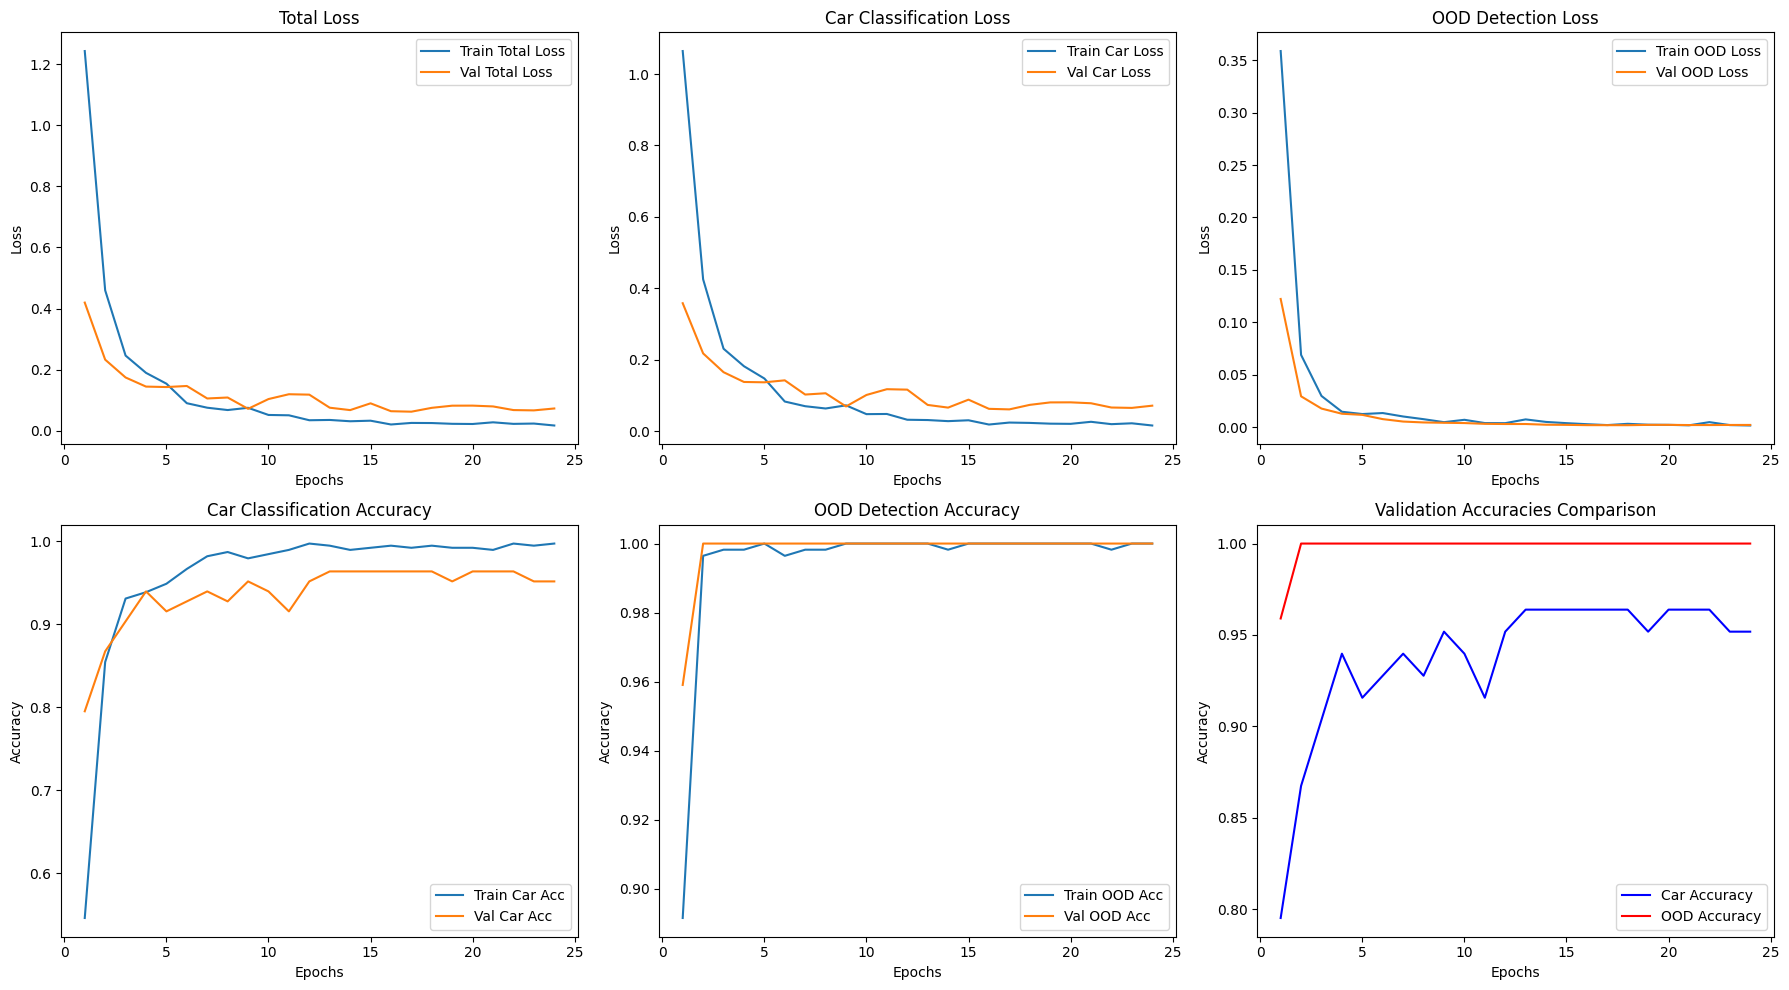

In [ ]:
EPOCHS = 50

if __name__ == "__main__":
    # Create early stopping object
    early_stopper = EarlyStopping(patience=7, min_delta=0.001)

    print("🚀 Starting training with Multi-Head OOD Detection...")

    # Execute training
    results = train_dual_head(model, train_dataloader, val_dataloader,
                             optimizer, EPOCHS, device, early_stopper, scheduler)

    # Final evaluation on test set
    test_loss, test_car_loss, test_ood_loss, test_car_acc, test_ood_acc = test_step_dual(
        model, test_dataloader, device
    )

    print(f"\n📊 Final Test Results:")
    print(f"Total Loss: {test_loss:.4f}")
    print(f"Car Classification - Loss: {test_car_loss:.4f} | Accuracy: {test_car_acc:.4f}")
    print(f"OOD Detection - Loss: {test_ood_loss:.4f} | Accuracy: {test_ood_acc:.4f}")

    # Visualize training progress
    plot_dual_metrics(results)


🔍 Testing OOD Detection with sample images...


/tmp/ipython-input-21395877.py:57: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


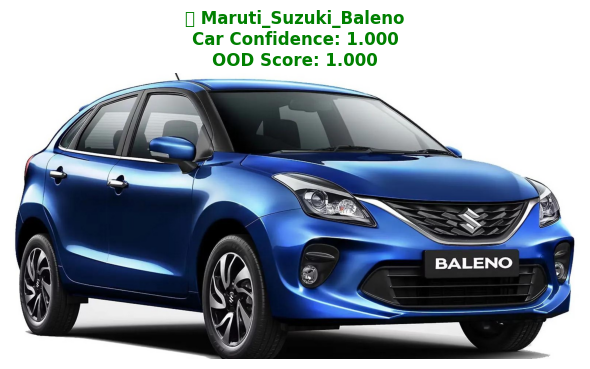

/tmp/ipython-input-21395877.py:57: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


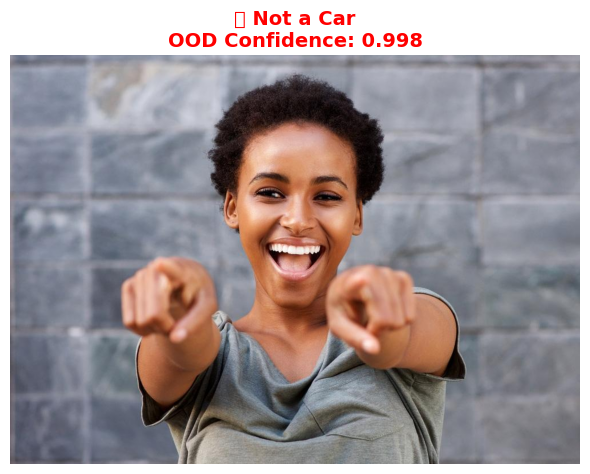

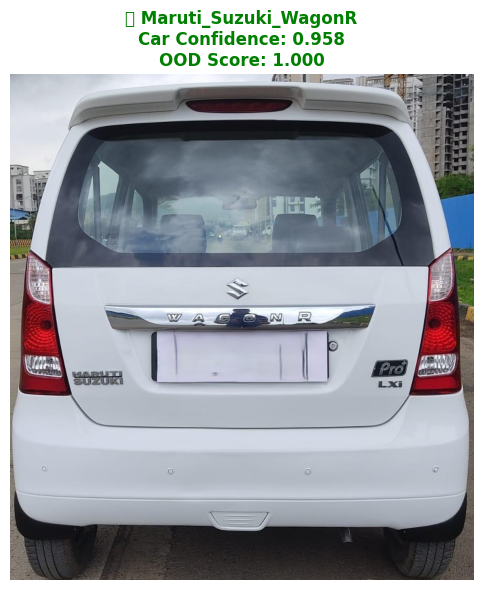

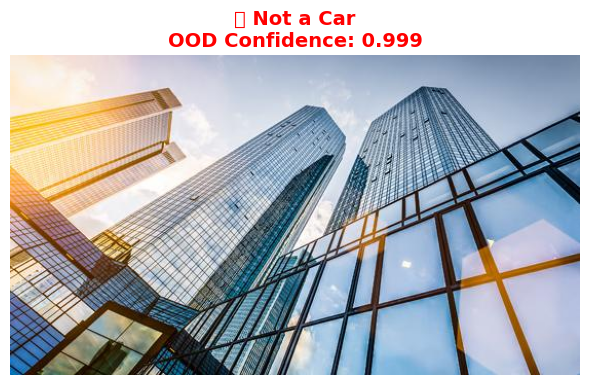

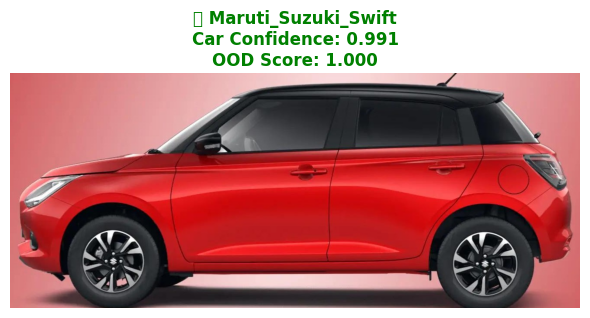

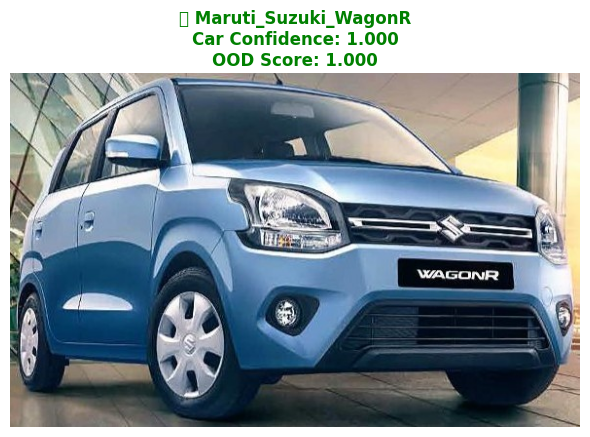

In [ ]:
print("\n🔍 Testing OOD Detection with sample images...")

# Test with sample images
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_sample = random.sample(population=test_image_path_list, k=6)

for image_path in test_image_sample:
    predict_with_ood_detection(model=model,
                              image_path=image_path,
                              class_names=class_names,
                              device=device,
                              ood_threshold=0.5)

✅ Swift (confidence: 100.0%)


/tmp/ipython-input-2532494644.py:46: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


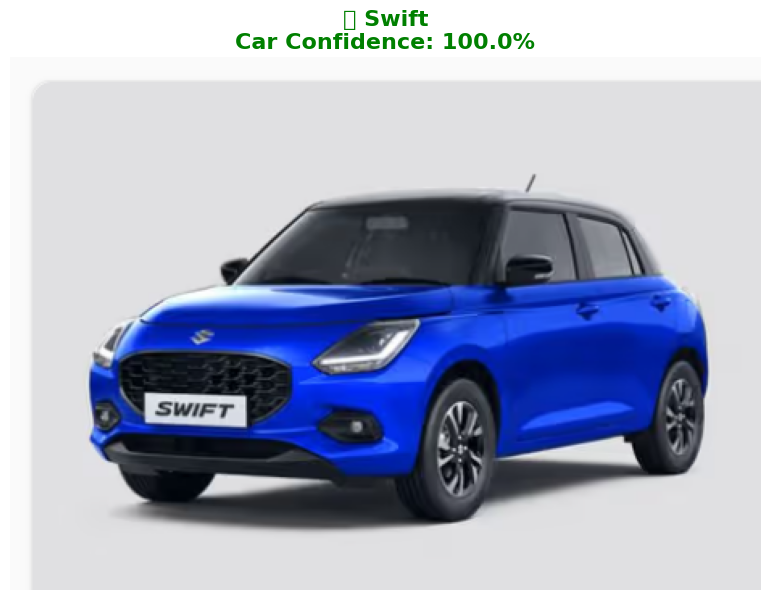

('✅ Swift', 'Car Confidence: 100.0%')

In [ ]:
import matplotlib.pyplot as plt

def simple_predict_with_image(image_path):
    """Ultra-simple prediction function with image display"""

    # Preprocessing
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load image for display (original)
    original_image = Image.open(image_path).convert('RGB')

    # Load and preprocess image for prediction
    input_tensor = preprocess(original_image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        car_logits, ood_logits = model(input_tensor)
        ood_prob = torch.sigmoid(ood_logits).item()

        if ood_prob < 0.5:
            prediction_text = f"❌ Not a Car"
            confidence_text = f"OOD Confidence: {(1-ood_prob)*100:.1f}%"
            title_color = 'red'
            print(f"❌ Not a Car (confidence: {(1-ood_prob)*100:.1f}%)")
        else:
            car_names = ['Baleno', 'Brezza', 'Swift', 'WagonR']
            predicted = torch.argmax(car_logits, dim=1).item()
            confidence = torch.softmax(car_logits, dim=1).max().item()

            prediction_text = f"✅ {car_names[predicted]}"
            confidence_text = f"Car Confidence: {confidence*100:.1f}%"
            title_color = 'green'
            print(f"✅ {car_names[predicted]} (confidence: {confidence*100:.1f}%)")

    # Display image with prediction
    plt.figure(figsize=(8, 6))
    plt.imshow(original_image)
    plt.title(f"{prediction_text}\n{confidence_text}",
              fontsize=16, fontweight='bold', color=title_color)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return prediction_text, confidence_text

# Usage
simple_predict_with_image("1.png")


# testing multiple images at once

/tmp/ipython-input-4026582213.py:69: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4026582213.py:69: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


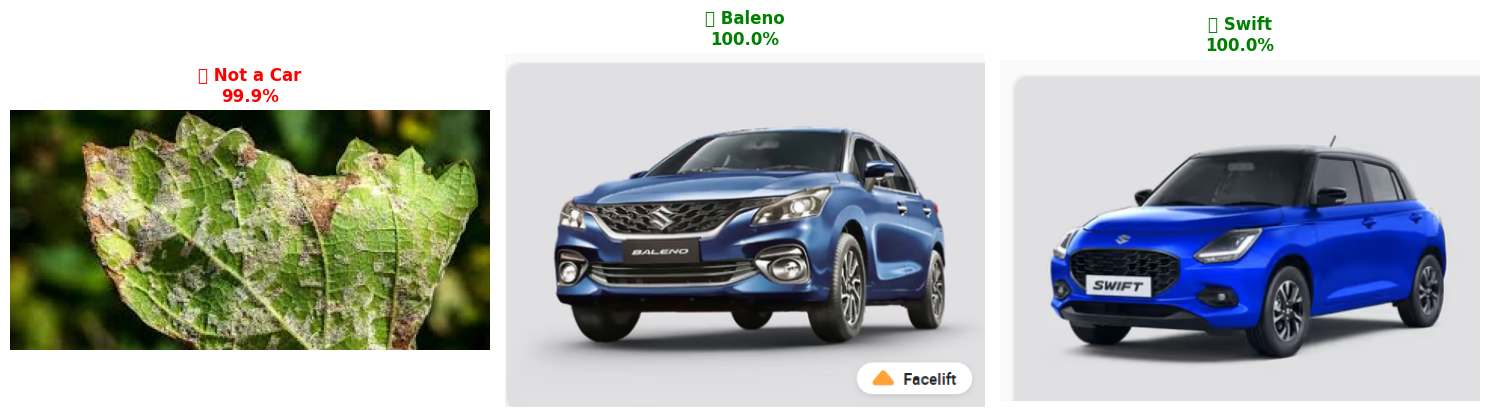

In [ ]:
def batch_predict_with_images_robust(image_paths):
    """Test multiple images and display them in a grid - robust version"""

    num_images = len(image_paths)
    cols = 3
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))

    # Normalize axes to always be indexable by [row][col]
    if rows == 1 and cols == 1:
        axes = [[axes]]  # Single subplot
    elif rows == 1:
        axes = [axes.flatten()]  # Single row, multiple columns
    elif cols == 1:
        axes = [[ax] for ax in axes.flatten()]  # Single column, multiple rows
    # For multiple rows and cols, axes is already 2D

    for idx, image_path in enumerate(image_paths):
        row = idx // cols
        col = idx % cols

        try:
            # Get prediction
            preprocess = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            image = Image.open(image_path).convert('RGB')
            input_tensor = preprocess(image).unsqueeze(0).to(device)

            model.eval()
            with torch.no_grad():
                car_logits, ood_logits = model(input_tensor)
                ood_prob = torch.sigmoid(ood_logits).item()

                if ood_prob < 0.5:
                    title = f"❌ Not a Car\n{(1-ood_prob)*100:.1f}%"
                    color = 'red'
                else:
                    car_names = ['Baleno', 'Brezza', 'Swift', 'WagonR']
                    predicted = torch.argmax(car_logits, dim=1).item()
                    confidence = torch.softmax(car_logits, dim=1).max().item()
                    title = f"✅ {car_names[predicted]}\n{confidence*100:.1f}%"
                    color = 'green'

            # Display - now consistently indexable
            ax = axes[row][col]
            ax.imshow(image)
            ax.set_title(title, fontsize=12, fontweight='bold', color=color)
            ax.axis('off')

        except Exception as e:
            # Handle any errors (file not found, etc.)
            ax = axes[row][col]
            ax.text(0.5, 0.5, f"Error:\n{str(e)}",
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"Error loading {image_path}", color='orange')
            ax.axis('off')

    # Hide empty subplots
    for idx in range(num_images, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row][col].axis('off')

    plt.tight_layout()
    plt.show()

# Usage for multiple images
image_list = ["2.jpg", "112.png", "1.png"]
batch_predict_with_images_robust(image_list)
